In [1]:
# Use for AWS SageMaker
# !pip install --upgrade pip
# !pip install gensim

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from src import utils, nmf_utils, nlp_topic_utils
from src.process_text_variables import contracted_words_dict, stop_words_dict, punc 

import re
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

from collections import Counter
from operator import itemgetter

# NMF - Wall Street Forum

In [3]:
def bow_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng):
    '''
    
    Args:
        
    Return:
    
    '''
    vectorizer = CountVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
    docs_vectorized = vectorizer.fit_transform(docs_raw)
    return docs_vectorized, vectorizer


In [4]:
def tfidf_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng):
    '''
    
    Args:
        
    Return:
    
    '''
    vectorizer = TfidfVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
    docs_vectorized = vectorizer.fit_transform(docs_raw)
    return docs_vectorized, vectorizer

In [5]:
def print_topics(model, count_vectorizer, n_top_words):
    '''
   
    Args:
    
        
    Return:
    
        
    '''
    
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        top_words_arr = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join(top_words_arr))

## Import Dataset and Model Inputs

In [6]:
wallstreet = pd.read_csv('data/wallstreet_master.csv')

In [7]:
wallstreet['nmf_tokens'] = wallstreet['processed_text'].apply(lambda x: nlp_topic_utils.process_text(x, contracted_words_dict, punc, stop_words_dict, min_len=1))

In [8]:
docs_raw = wallstreet['nmf_tokens']

---
## Use Gensim to Identify Optimal Number of Topics

In [10]:
gensim_dict, corpus = nmf_utils.create_gensim_dict_corpus(docs_raw, 3, 0.70, 10000)

In [11]:
num_topics_rng = list(np.arange(3, 42 + 1, 3)) 
coherence_scores = []

# NMF MODEL PARAMS
num_passes_over_training_docs = 5
gradient_desc_step = 0.1

# the "normalized" arg must equal true to be relevant.
floor_probs_for_topics = 0.005
normalize = True
num_training_docs_per_chunk = 5000

# W = topics by words
w_max_iter=300
w_stop_condition=0.0001

# H = articles by topics
h_max_iter=100
h_stop_condition=0.001
eval_every=10
random_state = 3

for num in num_topics_rng:
    nmf = Nmf(corpus=corpus, num_topics=num, id2word=gensim_dict, chunksize=num_training_docs_per_chunk,  passes=num_passes_over_training_docs, kappa=gradient_desc_step,
             normalize=normalize, minimum_probability=floor_probs_for_topics, w_max_iter=w_max_iter, w_stop_condition=w_stop_condition, h_max_iter=h_max_iter,
             h_stop_condition=h_stop_condition, eval_every=eval_every, random_state=random_state)
    
    coherence_model = CoherenceModel(model=nmf, texts=docs_raw, dictionary=gensim_dict, coherence='c_v')
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))

scores = list(zip(num_topics_rng, coherence_scores))
topics_sorted_by_co_score = sorted(scores, key=itemgetter(1), reverse=True)
print(topics_sorted_by_co_score)

[(3, 0.67304), (21, 0.6111), (12, 0.60421), (27, 0.57114), (33, 0.56746), (6, 0.55835), (9, 0.55457), (36, 0.54675), (24, 0.54468), (30, 0.54028), (42, 0.53337), (15, 0.53076), (18, 0.52794), (39, 0.52555)]


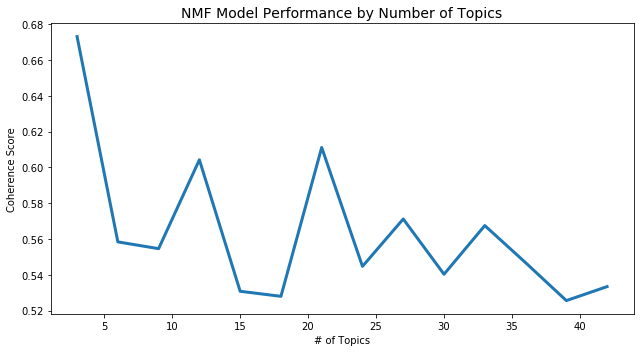

In [17]:
nmf_utils.plot_coherence_scores(num_topics_rng, scores)

---
# NMF Inputs

In [15]:
docs_raw_sklearn = wallstreet['processed_text']

---
# NMF - Bag of Words 

In [18]:
# bow_docs_vectorized,  bow_vectorizer = bow_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng)

best_num_topics = 12
min_doc_freq = 3

bow_vectorizer = CountVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
bow_docs_vectorized = bow_vectorizer.fit_transform(docs_raw_sklearn)
nmf_bow = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=3).fit(bow_docs_vectorized)

NameError: name 'max_doc_freq' is not defined

In [ ]:
n_top_words = 10

print_topics(nmf_bow, bow_vectorizer, n_top_words)

---
## NMF - Tf-Idf

In [ ]:
# bow_docs_vectorized,  bow_vectorizer = bow_vectorizer(docs_raw, min_doc_freq, max_doc_freq, max_feats, ngram_rng)

best_num_topics = 12

tfidf_vectorizer = TfidfVectorizer(min_df=min_doc_freq, max_df=max_doc_freq, max_features=max_feats, ngram_range=ngram_rng)
tfidf_docs_vectorized = tfidf_vectorizer.fit_transform(docs_raw_sklearn)
nmf_tfidf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=3).fit(tfidf_docs_vectorized)

In [ ]:
n_top_words = 10

print_topics(nmf_tfidf, tfidf_vectorizer, n_top_words)

### Evaluate nmf_tfidf Model Performance
Calculate the residuals

In [ ]:
A = tfidf_docs_vectorized
W = nmf_tfidf.components_
H = nmf_tfidf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))

In [ ]:
residuals = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    residuals[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), ord='fro')

sum_sqrt_resids = round(sum(np.sqrt(residuals)), 3)
print('Sum of the squared residuals: ', sum_sqrt_resids)

In [ ]:
def calc_nmf_residuals(docs_vectorized, vectorizer):
    '''
    Calculates the error among the true and predicted values.
    Sum of squared residuals is use to evaluate model performance.
    '''
    A = docs_vectorized
    W = vectorizer.components_
    H = vectorizer.transform(A)
    
    residuals = np.zeros(A.shape[0])

    for row in range(A.shape[0]):
        residuals[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), ord='fro')

    sum_sqrt_resids = round(sum(np.sqrt(residuals)), 3)
    print('Sum of the squared residuals: ', sum_sqrt_resids)

In [ ]:
calc_nmf_residuals(tfidf_docs_vectorized, nmf_tfidf)